In [ ]:
!pip install -q Wikipedia-API
!pip install -q spacy rapidfuzz networkx textstat SPARQLWrapper qwikidata pykeen
!python -m spacy download en_core_web_sm

  Preparing metadata (setup.py) ... done


In [77]:
import time
from SPARQLWrapper import SPARQLWrapper, JSON
from qwikidata.sparql import return_sparql_query_results
import wikipediaapi

from datasets import load_dataset
import spacy
import pandas as pd
from rapidfuzz import fuzz
import networkx as nx
import json
import re

import torch
import numpy as np
from pykeen.pipeline import pipeline
from pykeen.triples import TriplesFactory
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

from torch.utils.data import Dataset, DataLoader
from transformers import T5Tokenizer

import torch.nn as nn
from transformers import T5ForConditionalGeneration
import torch.optim as optim
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from transformers.modeling_outputs import BaseModelOutput


# Data Collection and Preparation

In [3]:
nlp = spacy.load("en_core_web_sm")
limit = 1000

def add_rel(key, pred, result, kg_data):
    if key in result:
        val = result[key]["value"]

        if "http" not in val:
            kg_data[e_id]["relations"].add((e_name, pred, val))


sparql = SPARQLWrapper("https://query.wikidata.org/sparql")

query = f"""
SELECT ?entity ?entityLabel ?positionLabel ?partyLabel ?birthDateLabel WHERE {{
  {{
    SELECT DISTINCT ?entity WHERE {{
      ?entity wdt:P31 wd:Q5;          # Человек
              wdt:P39 ?position.      # Занимает должность
      ?article schema:about ?entity;
                schema:isPartOf <https://en.wikipedia.org/>.
    }}
    LIMIT {limit}
  }}

  ?entity wdt:P39 ?position.
  OPTIONAL {{ ?entity wdt:P102 ?party. }}
  OPTIONAL {{ ?entity wdt:P569 ?birthDate. }}

  SERVICE wikibase:label {{ bd:serviceParam wikibase:language "en". }}
}}
"""

sparql.setQuery(query)
sparql.setReturnFormat(JSON)

results = sparql.query().convert()

kg_data = {}

for result in results["results"]["bindings"]:
    e_uri = result["entity"]["value"]
    e_id = e_uri.split("/")[-1]
    e_name = result["entityLabel"]["value"]

    if e_id not in kg_data:
        kg_data[e_id] = {
            "name": e_name,
            "relations": set()
        }

    add_rel("positionLabel", "holds_position", result, kg_data)
    add_rel("partyLabel", "member_of_political_party", result, kg_data)

    # берем только год для простоты
    if "birthDateLabel" in result:
        date_val = result["birthDateLabel"]["value"]
        year = date_val[:4]
        kg_data[e_id]["relations"].add((e_name, "born_in_year", year))

print(f"Найдено сущностей в графе: {len(kg_data)}")


Найдено сущностей в графе: 300


In [4]:
list(kg_data.items())[0]

('Q2866678',
 {'name': 'Askia Daoud',
  'relations': {('Askia Daoud', 'born_in_year', '1600'),
   ('Askia Daoud', 'holds_position', 'monarch')}})

In [5]:
wiki_wiki = wikipediaapi.Wikipedia(
    user_agent='SNA-project/1.0 (iakhamganov@edu.hse.ru)',
    language='en',
    extract_format=wikipediaapi.ExtractFormat.WIKI
)

dataset = []

for e_id, info in list(kg_data.items()):

    page = wiki_wiki.page(info['name'])

    if not page.exists():
        print(f"отсутствует: {info['name']}")
        continue

    summary_text = page.summary #смак данных

    if len(summary_text) < 50:
        continue

    dataset.append({
        "entity_id": e_id,
        "entity_name": info['name'],
        "triples": list(info['relations']),
        "full_text": summary_text
    })

    time.sleep(0.5)

отсутствует: Gerren
отсутствует: Ranbir Singh I of Jind
отсутствует: Madansinh I of Kutch
отсутствует: Adolf I, Duke of Schleswig-Holstein-Gottorp
отсутствует: Prince Aimone, 4th Duke of Aosta
отсутствует: ʿUmar Tal
отсутствует: Milan I Obrenović
отсутствует: Alric
отсутствует: Heonae
отсутствует: Samsènethaï
отсутствует: M'siri
отсутствует: Sumalia Ndewura Jakpa
отсутствует: Oba Mufutau Gbadamosi Esuwoye
отсутствует: Bou Ahmed
отсутствует: Mehmed Emin Âli Paşa
отсутствует: Köprülü Fazıl Mustafa Paşa
отсутствует: Sinan the Great


In [6]:
raw_dataset = dataset
len(raw_dataset)

277

In [7]:
raw_dataset[0]

{'entity_id': 'Q2866678',
 'entity_name': 'Askia Daoud',
 'triples': [('Askia Daoud', 'holds_position', 'monarch'),
  ('Askia Daoud', 'born_in_year', '1600')],
 'full_text': 'Askia Daoud (also Askia Dāwūd, Askiya Dawud) was the ruler of the Songhai Empire from 1549 to 1582. His rule saw the empire rise to a peak of peace and prosperity  following a series of succession disputes and short reigns.'}

In [31]:
nlp(raw_dataset[0]['full_text'])

Tipu Sultan (Urdu: [ʈiːpuː sʊlt̪aːn], Kannada: [ʈipːu sult̪aːn], Sultan Fateh Ali Sahab Tipu; 1 December 1751 – 4 May 1799), commonly referred to as Sher-e-Mysore (Tiger of Mysore), was the Sultan of Mysore from 1782 until his death in 1799. He was a pioneer of rocket artillery. He expanded the iron-cased Mysorean rockets and commissioned the military manual Fathul Mujahidin. The economy of Mysore reached a zenith during his reign. He deployed rockets against advances of British forces and their allies during the Anglo-Mysore Wars, including the Battle of Pollilur and Siege of Srirangapatna.
Tipu Sultan and his father Hyder Ali used their French-trained army in alliance with the French in their struggle with the British, and in Mysore's struggles with other surrounding powers: against the Marathas, Sira, and rulers of Malabar, Kodagu, Bednore, Carnatic, and Travancore. Tipu became the ruler of Mysore upon his father's death from cancer in 1782 during the Second Anglo-Mysore War. He neg

**Выравнивание и препроцессинг**

In [8]:
def clean_sentence(text):
    text = re.sub(r'\[\d+\]', '', text)
    text = re.sub(r'\s+', ' ', text)
    return text.strip()

def linearize_graph(triples):
    # Превращаем граф в строку: <H> Subj <R> Pred <T> Obj
    linearized = []
    for subj, pred, obj in triples:
        linearized.append(f"<H> {subj} <R> {pred} <T> {obj}")
    return " [SEP] ".join(linearized)

def align_and_generate_samples(dataset):
    final_samples = []

    for entry in dataset:
        doc = nlp(entry['full_text'])
        all_triples = entry['triples']

        for sent in doc.sents:
            sent_text = clean_sentence(sent.text)
            if len(sent_text) < 20: continue

            matched_triples = []

            for subj, pred, obj in all_triples:
                if obj in sent_text:
                    matched_triples.append((subj, pred, obj))

            if matched_triples:
                sample = {
                    "input_graph": linearize_graph(matched_triples),
                    "target_text": sent_text,
                    "entity": entry['entity_name']
                }
                final_samples.append(sample)

    return final_samples

In [9]:
training_data = align_and_generate_samples(raw_dataset)

print(f"{len(training_data)=}")

print(training_data[0]['input_graph'])
print(training_data[0]['target_text'])

len(training_data)=263
<H> Bitòn Coulibaly <R> born_in_year <T> 1689
Bitòn Coulibaly (1689?–1755), also known as Mamary Coulibaly, founded the Bambara Empire in what is now Mali's Ségou Region and Mopti Region.


In [10]:
triples_list = []

for q_id, info in kg_data.items():
    for triple in info['relations']:
        triples_list.append(list(triple))

triples_np = np.array(triples_list)

print(f"{len(triples_np)=}")
print(f"{triples_np[0]=}")

len(triples_np)=1103
triples_np[0]=array(['Askia Daoud', 'holds_position', 'monarch'], dtype='<U95')


**Создание TriplesFactory**

In [11]:
tf = TriplesFactory.from_labeled_triples(triples_np)

entity_to_id = tf.entity_to_id
relation_to_id = tf.relation_to_id

print(f"Уникальных сущностей: {tf.num_entities}")
print(f"Уникальных отношений: {tf.num_relations}")

Уникальных сущностей: 802
Уникальных отношений: 3


## Обучение модели TransE

In [12]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

result = pipeline(
    training=tf,
    testing=tf,
    model='TransE',

    model_kwargs={'embedding_dim': 64},
    optimizer='Adam',
    optimizer_kwargs={'lr': 0.01},
    training_kwargs={'num_epochs': 100},

    random_seed=42,
    device=device
)

INFO:pykeen.pipeline.api:Using device: cuda
INFO:pykeen.nn.representation:Inferred unique=False for Embedding()
INFO:pykeen.nn.representation:Inferred unique=False for Embedding()


Training epochs on cuda:0:   0%|          | 0/100 [00:00<?, ?epoch/s]

Training batches on cuda:0:   0%|          | 0.00/5.00 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/5.00 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/5.00 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/5.00 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/5.00 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/5.00 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/5.00 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/5.00 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/5.00 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/5.00 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/5.00 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/5.00 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/5.00 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/5.00 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/5.00 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/5.00 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/5.00 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/5.00 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/5.00 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/5.00 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/5.00 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/5.00 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/5.00 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/5.00 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/5.00 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/5.00 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/5.00 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/5.00 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/5.00 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/5.00 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/5.00 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/5.00 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/5.00 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/5.00 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/5.00 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/5.00 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/5.00 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/5.00 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/5.00 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/5.00 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/5.00 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/5.00 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/5.00 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/5.00 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/5.00 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/5.00 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/5.00 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/5.00 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/5.00 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/5.00 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/5.00 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/5.00 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/5.00 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/5.00 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/5.00 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/5.00 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/5.00 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/5.00 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/5.00 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/5.00 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/5.00 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/5.00 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/5.00 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/5.00 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/5.00 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/5.00 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/5.00 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/5.00 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/5.00 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/5.00 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/5.00 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/5.00 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/5.00 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/5.00 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/5.00 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/5.00 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/5.00 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/5.00 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/5.00 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/5.00 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/5.00 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/5.00 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/5.00 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/5.00 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/5.00 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/5.00 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/5.00 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/5.00 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/5.00 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/5.00 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/5.00 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/5.00 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/5.00 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/5.00 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/5.00 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/5.00 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/5.00 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/5.00 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/5.00 [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/5.00 [00:00<?, ?batch/s]

Evaluating on cuda:0:   0%|          | 0.00/1.10k [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.26s seconds


**Извлечение и сохранение эмбеддингов**

In [13]:
model = result.model

entity_embeddings_matrix = model.entity_representations[0](indices=None).detach().cpu().numpy()
entity_embedding_dict = {}

for entity_name, entity_id in entity_to_id.items():
    vector = entity_embeddings_matrix[entity_id]
    entity_embedding_dict[entity_name] = vector

In [14]:
sample_entity = 'Philip II of Spain'
print(f"{entity_embedding_dict[sample_entity].shape=}")
entity_embedding_dict[sample_entity][:5]

entity_embedding_dict[sample_entity].shape=(64,)


array([-0.05190628,  0.21812817,  0.15853664, -0.02138222,  0.17868848],
      dtype=float32)

# Develop mechanisms to incorporate these embeddings as additional inputs or conditioning contexts for language models.

In [15]:
class GraphTextDataset(Dataset):
    def __init__(self, data, entity_embeddings, tokenizer, max_len=128):
        """
        data: список словарей из training_data
        entity_embeddings: словарь {name: numpy_vector}
        """
        self.data = data
        self.entity_embeddings = entity_embeddings
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.embedding_dim = 64 # размерность TransE векторов

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]

        input_text = "generate text from graph: " + item['input_graph']
        target_text = item['target_text']
        entity_name = item['entity']

        source = self.tokenizer(
            input_text,
            max_length=self.max_len,
            padding="max_length",
            truncation=True,
            return_tensors="pt"
        )

        target = self.tokenizer(
            target_text,
            max_length=self.max_len,
            padding="max_length",
            truncation=True,
            return_tensors="pt"
        )


        if entity_name in self.entity_embeddings:
            graph_vec = self.entity_embeddings[entity_name]
            graph_vec = torch.tensor(graph_vec, dtype=torch.float32)
        else:
            graph_vec = torch.zeros(self.embedding_dim, dtype=torch.float32)

        return {
            "input_ids": source["input_ids"].squeeze(),
            "attention_mask": source["attention_mask"].squeeze(),
            "labels": target["input_ids"].squeeze(),
            "graph_vector": graph_vec
        }

tokenizer = T5Tokenizer.from_pretrained("t5-small")

dataset = GraphTextDataset(training_data, entity_embedding_dict, tokenizer)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


In [48]:
batch = next(iter(dataloader))
print(f"Shape входных токенов: {batch['input_ids'].shape}")
print(f"Shape графовых векторов: {batch['graph_vector'].shape}")

Shape входных токенов: torch.Size([4, 128])
Shape графовых векторов: torch.Size([4, 64])


In [16]:
class GraphAugmentedT5(nn.Module):
    def __init__(self, model_name, graph_dim=64):
        super().__init__()
        self.t5 = T5ForConditionalGeneration.from_pretrained(model_name)
        self.hidden_dim = self.t5.config.d_model

        self.graph_projector = nn.Linear(graph_dim, self.hidden_dim)
        nn.init.xavier_uniform_(self.graph_projector.weight)

    def _prepare_inputs(self, input_ids, attention_mask, graph_vector):
        """Подготовка склеенных эмбеддингов и маски"""
        # Текст -> Эмбеддинги
        inputs_embeds = self.t5.shared(input_ids)

        # Граф -> Эмбеддинги
        graph_emb = self.graph_projector(graph_vector).unsqueeze(1)

        # склейка граф и текст
        inputs_embeds_combined = torch.cat([graph_emb, inputs_embeds], dim=1)

        # Расширение маски
        batch_size = attention_mask.shape[0]
        ones = torch.ones((batch_size, 1), device=attention_mask.device, dtype=attention_mask.dtype)
        extended_mask = torch.cat([ones, attention_mask], dim=1)

        return inputs_embeds_combined, extended_mask

    def forward(self, input_ids, attention_mask, graph_vector, labels=None):
        inputs_embeds, extended_mask = self._prepare_inputs(input_ids, attention_mask, graph_vector)
        return self.t5(inputs_embeds=inputs_embeds, attention_mask=extended_mask, labels=labels)

    def generate(self, input_ids, attention_mask, graph_vector, max_length=100):
        inputs_embeds, extended_mask = self._prepare_inputs(input_ids, attention_mask, graph_vector)

        return self.t5.generate(
            inputs_embeds=inputs_embeds,
            attention_mask=extended_mask,
            max_length=max_length,
            num_beams=4,
            no_repeat_ngram_size=2,
            early_stopping=True
        )

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = GraphAugmentedT5(model_name="t5-small", graph_dim=64)
model.to(device)
print()

config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

# Language Model Adaptation

## Fine-tune existing pretrained language models by integrating graph embeddings through specialized adapters or graph-aware attention mechanisms.

In [17]:
BATCH_SIZE = 4
LEARNING_RATE = 3e-4
NUM_EPOCHS = 10
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

DEVICE

'cuda'

In [19]:
train_loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE)
loss_history = []

for epoch in range(NUM_EPOCHS):
    model.train()
    total_loss = 0

    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}")

    for batch in pbar:
        optimizer.zero_grad()

        input_ids = batch['input_ids'].to(device)
        mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        graph_vec = batch['graph_vector'].to(device)

        outputs = model(input_ids, mask, graph_vec, labels=labels)
        loss = outputs.loss

        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        pbar.set_postfix({'loss': loss.item()})
        loss_history.append(loss.item())

    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch+1} finished. Avg Loss: {avg_loss:.4f}")

    model.eval()
    with torch.no_grad():
        batch = next(iter(train_loader))
        input_ids = batch['input_ids'][0:1].to(device)
        mask = batch['attention_mask'][0:1].to(device)
        graph_vec = batch['graph_vector'][0:1].to(device)

        out = model.generate(input_ids, mask, graph_vec, max_length=60)
        text = tokenizer.decode(out[0], skip_special_tokens=True)

        print(f"Model Output: {text}")
        print()

Epoch 1:   0%|          | 0/66 [00:00<?, ?it/s]

Epoch 1 finished. Avg Loss: 1.2750
Model Output: H> Liliuokalani () is a British monarch who served as the first monarch of the U.S.



Epoch 2:   0%|          | 0/66 [00:00<?, ?it/s]

Epoch 2 finished. Avg Loss: 1.0958
Model Output: Samuel Chase (born 18 January 1741) is an American lawyer and jurist who served as an associate justice of the United States Supreme Court, serving as a judge and judge, and was the first person to serve in the U.S. Senate.



Epoch 3:   0%|          | 0/66 [00:00<?, ?it/s]

Epoch 3 finished. Avg Loss: 1.0096
Model Output: Victor Amadeus II, Duke of Savoye, was a German politician who served as Chancellor of the Kingdom of Saviour from 1830 until his death in 1815.



Epoch 4:   0%|          | 0/66 [00:00<?, ?it/s]

Epoch 4 finished. Avg Loss: 0.9462
Model Output: He served as Deputy Leader of the Labour Party from 1999 to 2010.



Epoch 5:   0%|          | 0/66 [00:00<?, ?it/s]

Epoch 5 finished. Avg Loss: 0.8923
Model Output: Tamatoa VI (c. 1853 – 17 September 1867) was an American lawyer and jurist who served as the first president of the United States from 1898 until his death.



Epoch 6:   0%|          | 0/66 [00:00<?, ?it/s]

Epoch 6 finished. Avg Loss: 0.8378
Model Output: Callaghan was a member of the Labour Party from 1975 to 1980 and was elected to the House of Commons in 1972.



Epoch 7:   0%|          | 0/66 [00:00<?, ?it/s]

Epoch 7 finished. Avg Loss: 0.7943
Model Output: Sh Shin (c. 1465 – 17 December 1467), also known as Shy Shin, was a Chinese politician who served as the first president of the United Kingdom from 1498 until his death.



Epoch 8:   0%|          | 0/66 [00:00<?, ?it/s]

Epoch 8 finished. Avg Loss: 0.7433
Model Output: Byrnes is a member of the Democratic Party.



Epoch 9:   0%|          | 0/66 [00:00<?, ?it/s]

Epoch 9 finished. Avg Loss: 0.7049
Model Output: He was appointed Shadow Chancellor of the Exchequer by the House of Commons in 1931.



Epoch 10:   0%|          | 0/66 [00:00<?, ?it/s]

Epoch 10 finished. Avg Loss: 0.6670
Model Output: She was a former partner of the same name in the House of Representatives of New York and the first woman to have been married for over two decades.



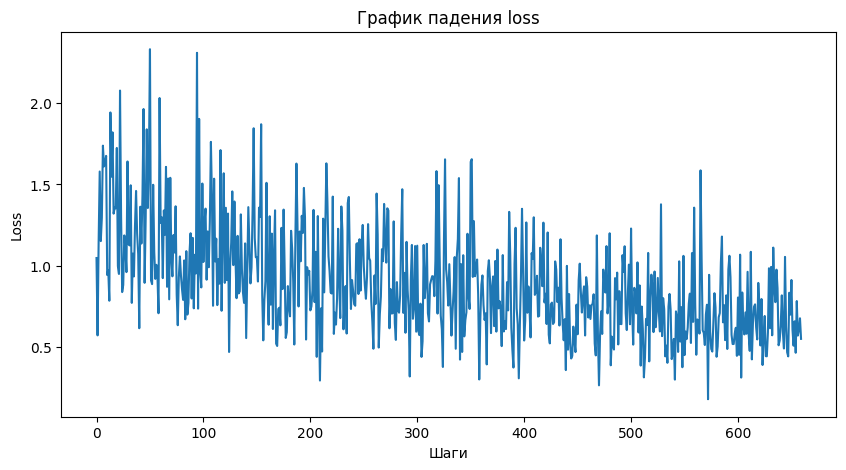

Модель сохранена в файл 'graph_t5_finetuned.pth'


In [20]:
plt.figure(figsize=(10, 5))
plt.plot(loss_history)
plt.title("График падения loss")
plt.xlabel("Шаги")
plt.ylabel("Loss")
plt.show()

torch.save(model.state_dict(), "graph_t5_finetuned.pth")

**Небольшой инференс**

In [21]:
model.eval()
test_idx = 0
item = dataset[test_idx]

input_ids = item['input_ids'].unsqueeze(0).to(DEVICE)
mask = item['attention_mask'].unsqueeze(0).to(DEVICE)
graph_vec = item['graph_vector'].unsqueeze(0).to(DEVICE)


with torch.no_grad():
    output_ids = model.generate(input_ids, mask, graph_vec, max_length=100)

pred_text = tokenizer.decode(output_ids[0], skip_special_tokens=True)
real_text = tokenizer.decode(item['labels'], skip_special_tokens=True)
input_graph_str = training_data[test_idx]['input_graph']

print(f"INPUT GRAPH: {input_graph_str}")
print(f"TARGET TEXT: {real_text}")
print(f"GENERATED:   {pred_text}")

INPUT GRAPH: <H> Bitòn Coulibaly <R> born_in_year <T> 1689
TARGET TEXT: Bitn Coulibaly (1689?–1755), also known as Mamary Coulibaly, founded the Bambara Empire in what is now Mali's Ségou Region and Mopti Region.
GENERATED:   Bitn Coulibaly (c. 1689–1643) was an American lawyer and jurist who served as an associate justice of the Supreme Court from 1699 until his death in 1685.


## Experiment with different architectures, including hybrid approaches like Graph Transformer models, to optimally combine textual and graph-based information.

In [22]:
class HybridGraphT5(nn.Module):
    def __init__(self, model_name, graph_dim=64):
        super().__init__()
        self.t5 = T5ForConditionalGeneration.from_pretrained(model_name)
        self.hidden_dim = self.t5.config.d_model

        self.graph_projector = nn.Linear(graph_dim, self.hidden_dim)
        self.fusion_norm = nn.LayerNorm(self.hidden_dim)

        nn.init.xavier_uniform_(self.graph_projector.weight)

    def _fuse_graph_and_text(self, input_ids, attention_mask, graph_vector):
        """
        Слияние на выходе энкодера
        """
        # Прогоняем текст через энкодер T5
        # Получаем hidden states (Batch, Seq_Len, 512)
        text_encoder_outputs = self.t5.encoder(
            input_ids=input_ids,
            attention_mask=attention_mask
        ).last_hidden_state

        # Готовим граф
        # (Batch, 64) -> (Batch, 512) -> (Batch, 1, 512)
        graph_emb = self.graph_projector(graph_vector).unsqueeze(1)
        graph_emb = self.fusion_norm(graph_emb)

        fused_hidden_states = torch.cat([text_encoder_outputs, graph_emb], dim=1)

        batch_size = attention_mask.shape[0]
        ones = torch.ones((batch_size, 1), device=attention_mask.device, dtype=attention_mask.dtype)
        fused_mask = torch.cat([attention_mask, ones], dim=1)

        return fused_hidden_states, fused_mask

    def forward(self, input_ids, attention_mask, graph_vector, labels=None):
        fused_hidden_states, fused_mask = self._fuse_graph_and_text(input_ids, attention_mask, graph_vector) #объединенное представление
        encoder_outputs = BaseModelOutput(last_hidden_state=fused_hidden_states)

        return self.t5(
            encoder_outputs=encoder_outputs,
            attention_mask=fused_mask,
            labels=labels
        )

    def generate(self, input_ids, attention_mask, graph_vector, max_length=100):
        fused_hidden_states, fused_mask = self._fuse_graph_and_text(input_ids, attention_mask, graph_vector)
        encoder_outputs = BaseModelOutput(last_hidden_state=fused_hidden_states)

        return self.t5.generate(
            encoder_outputs=encoder_outputs,
            attention_mask=fused_mask,
            max_length=max_length,
            num_beams=4,
            no_repeat_ngram_size=2,
            early_stopping=True
        )

In [25]:
hybrid_model = HybridGraphT5(model_name="t5-small", graph_dim=64)
hybrid_model.to(device)
print()

In [23]:
BATCH_SIZE = 4
LEARNING_RATE = 3e-4
NUM_EPOCHS = 10
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [26]:
train_loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

optimizer = optim.AdamW(hybrid_model.parameters(), lr=LEARNING_RATE)
loss_history = []

for epoch in range(NUM_EPOCHS):
    hybrid_model.train()
    total_loss = 0
    pbar = tqdm(train_loader, desc=f"Hybrid Epoch {epoch+1}")

    for batch in pbar:
        optimizer.zero_grad()

        input_ids = batch['input_ids'].to(device)
        mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        graph_vec = batch['graph_vector'].to(device)

        outputs = hybrid_model(input_ids, mask, graph_vec, labels=labels)
        loss = outputs.loss

        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        pbar.set_postfix({'loss': loss.item()})
        loss_history.append(loss.item())

    print(f"Epoch {epoch+1} finished. Avg Loss: {total_loss / len(train_loader):.4f}")

torch.save(hybrid_model.state_dict(), "hybrid_graph_t5.pth")

Hybrid Epoch 1:   0%|          | 0/66 [00:00<?, ?it/s]

Epoch 1 finished. Avg Loss: 3.3435


Hybrid Epoch 2:   0%|          | 0/66 [00:00<?, ?it/s]

Epoch 2 finished. Avg Loss: 1.4635


Hybrid Epoch 3:   0%|          | 0/66 [00:00<?, ?it/s]

Epoch 3 finished. Avg Loss: 1.2781


Hybrid Epoch 4:   0%|          | 0/66 [00:00<?, ?it/s]

Epoch 4 finished. Avg Loss: 1.1682


Hybrid Epoch 5:   0%|          | 0/66 [00:00<?, ?it/s]

Epoch 5 finished. Avg Loss: 1.0566


Hybrid Epoch 6:   0%|          | 0/66 [00:00<?, ?it/s]

Epoch 6 finished. Avg Loss: 0.9892


Hybrid Epoch 7:   0%|          | 0/66 [00:00<?, ?it/s]

Epoch 7 finished. Avg Loss: 0.9311


Hybrid Epoch 8:   0%|          | 0/66 [00:00<?, ?it/s]

Epoch 8 finished. Avg Loss: 0.8883


Hybrid Epoch 9:   0%|          | 0/66 [00:00<?, ?it/s]

Epoch 9 finished. Avg Loss: 0.8496


Hybrid Epoch 10:   0%|          | 0/66 [00:00<?, ?it/s]

Epoch 10 finished. Avg Loss: 0.8107


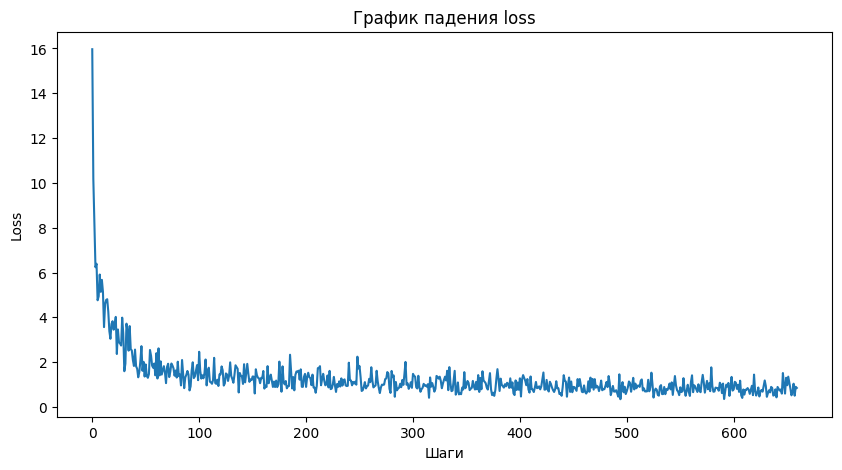

In [27]:
plt.figure(figsize=(10, 5))
plt.plot(loss_history)
plt.title("График падения loss")
plt.xlabel("Шаги")
plt.ylabel("Loss")
plt.show()

In [29]:
hybrid_model.eval()
test_idx = 0
item = dataset[test_idx]

input_ids = item['input_ids'].unsqueeze(0).to(DEVICE)
mask = item['attention_mask'].unsqueeze(0).to(DEVICE)
graph_vec = item['graph_vector'].unsqueeze(0).to(DEVICE)


with torch.no_grad():
    output_ids = model.generate(input_ids, mask, graph_vec, max_length=100)

pred_text = tokenizer.decode(output_ids[0], skip_special_tokens=True)
real_text = tokenizer.decode(item['labels'], skip_special_tokens=True)
input_graph_str = training_data[test_idx]['input_graph']

print(f"INPUT GRAPH: {input_graph_str}")
print(f"TARGET TEXT: {real_text}")
print(f"GENERATED:   {pred_text}")

INPUT GRAPH: <H> Bitòn Coulibaly <R> born_in_year <T> 1689
TARGET TEXT: Bitn Coulibaly (1689?–1755), also known as Mamary Coulibaly, founded the Bambara Empire in what is now Mali's Ségou Region and Mopti Region.
GENERATED:   Bitn Coulibaly (c. 1689–1643) was an American lawyer and jurist who served as an associate justice of the Supreme Court from 1699 until his death in 1685.


# Оценка метрик

In [30]:
!pip install -q evaluate rouge_score sacrebleu nltk

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 kB 9.2 MB/s eta 0:00:00


In [31]:
import evaluate
import nltk

In [32]:
nltk.download('wordnet')
nltk.download('punkt')

bleu = evaluate.load("bleu")
rouge = evaluate.load("rouge")
meteor = evaluate.load("meteor")

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [73]:
def calculate_metrics(model, dataloader, tokenizer, device='cuda'):
    model.eval()

    predictions = []
    references = []
    inputs_graphs = []

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating"):
            input_ids = batch['input_ids'].to(device)
            mask = batch['attention_mask'].to(device)
            graph_vec = batch['graph_vector'].to(device)

            gen_tokens = model.generate(
                input_ids,
                mask,
                graph_vec,
                max_length=128
            )

            preds = tokenizer.batch_decode(gen_tokens, skip_special_tokens=True)

            labels = batch['labels'].cpu().numpy()
            labels[labels == -100] = tokenizer.pad_token_id
            refs = tokenizer.batch_decode(labels, skip_special_tokens=True)

            in_graphs = tokenizer.batch_decode(batch['input_ids'], skip_special_tokens=False)

            predictions.extend(preds)
            references.extend(refs)
            inputs_graphs.extend(in_graphs)

    results_bleu = bleu.compute(predictions=predictions, references=[[r] for r in references])
    results_rouge = rouge.compute(predictions=predictions, references=references)
    results_meteor = meteor.compute(predictions=predictions, references=references)

    scores = {
        "BLEU": results_bleu['bleu'],
        "ROUGE-1": results_rouge['rouge1'],
        "ROUGE-2": results_rouge['rouge2'],
        "ROUGE-L": results_rouge['rougeL'],
        "METEOR": results_meteor['meteor']
    }

    return scores, inputs_graphs, predictions, references

In [74]:
eval_loader = DataLoader(dataset, batch_size=4, shuffle=False)

# model = HybridGraphT5(model_name="t5-small", graph_dim=64)
# model.load_state_dict(torch.load("/content/hybrid_graph_t5.pth"))
# model.to(device)

scores_hybrid, inputs_hybrid, preds_hybrid, refs_hybrid = calculate_metrics(hybrid_model, eval_loader, tokenizer, device)

# model = GraphAugmentedT5(model_name="t5-small", graph_dim=64)
# model.load_state_dict(torch.load("/content/graph_t5_finetuned.pth"))
# model.to(device)

scores_grapht5, inputs_grapht5, preds_grapht5, refs_grapht5 = calculate_metrics(model, eval_loader, tokenizer, device)

df_scores = pd.DataFrame([scores_hybrid, scores_grapht5])
df_scores.index = ['Hybrid', 'GraphT5']
print(df_scores)

Evaluating:   0%|          | 0/66 [00:00<?, ?it/s]

Computing metrics...


Evaluating:   0%|          | 0/66 [00:00<?, ?it/s]

Computing metrics...
             BLEU   ROUGE-1   ROUGE-2   ROUGE-L    METEOR
Hybrid   0.153241  0.400565  0.217895  0.357382  0.333952
GraphT5  0.158269  0.408925  0.231305  0.367795  0.344267


## factual correctness

In [76]:
original_inputs = [item['input_graph'] for item in training_data]

min_len = min(len(original_inputs), len(preds_grapht5), len(preds_hybrid))
original_inputs_safe = original_inputs[:min_len]
preds_grapht5_safe = preds_grapht5[:min_len]
preds_hybrid_safe = preds_hybrid[:min_len]

def evaluate_factual_coverage_v2(inputs, predictions):
    total_facts = 0
    covered_facts = 0

    regex_pattern = r"<T>\s*(.*?)(?=\s*(?:\[SEP\]|<H>|$))"

    for graph_str, pred_text in zip(inputs, predictions):
        # Ищем все объекты в графе
        matches = re.findall(regex_pattern, graph_str)
        objects = [m.strip() for m in matches if len(m.strip()) > 0]

        pred_lower = pred_text.lower()

        for obj in objects:
            total_facts += 1
            if obj.lower() in pred_lower:
                covered_facts += 1

    return covered_facts / total_facts if total_facts > 0 else 0

score_g5 = evaluate_factual_coverage_v2(original_inputs_safe, preds_grapht5_safe)
score_hybrid = evaluate_factual_coverage_v2(original_inputs_safe, preds_hybrid_safe)

print(f"GraphT5: {score_g5*100:.2f}%")
print(f"Hybrid:  {score_hybrid*100:.2f}%")

GraphT5: 92.07%
Hybrid:  94.21%


## standard pretrained LMs without graph integration

In [79]:
class BaselineTextDataset(Dataset):
    def __init__(self, data, tokenizer, max_len=128):
        """
        data: список словарей из training_data (Step 1)
        """
        self.data = data
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        input_text = f"generate text about {item['entity']}:"

        target_text = item['target_text']

        source = self.tokenizer(
            input_text,
            max_length=self.max_len,
            padding="max_length",
            truncation=True,
            return_tensors="pt"
        )

        target = self.tokenizer(
            target_text,
            max_length=self.max_len,
            padding="max_length",
            truncation=True,
            return_tensors="pt"
        )

        return {
            "input_ids": source["input_ids"].squeeze(),
            "attention_mask": source["attention_mask"].squeeze(),
            "labels": target["input_ids"].squeeze(),
        }

In [83]:
train_data_list, val_data_list = train_test_split(training_data, test_size=0.2, random_state=42)

print(len(train_data_list))
print(len(val_data_list))

210
53


In [84]:
BATCH_SIZE = 4
train_dataset_base = BaselineTextDataset(train_data_list, tokenizer)
train_loader_base = DataLoader(train_dataset_base, batch_size=BATCH_SIZE, shuffle=True)

val_dataset_base = BaselineTextDataset(val_data_list, tokenizer)
val_loader_base = DataLoader(val_dataset_base, batch_size=BATCH_SIZE, shuffle=False)

In [85]:
baseline_model = T5ForConditionalGeneration.from_pretrained("t5-small")
baseline_model.to(device)

history_loss = []
def train_baseline(model, train_loader, epochs=10, lr=3e-4):
    optimizer = optim.AdamW(model.parameters(), lr=lr)
    model.train()

    for epoch in range(epochs):
        total_loss = 0
        pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}", leave=False)

        for batch in pbar:
            optimizer.zero_grad()

            input_ids = batch['input_ids'].to(device)
            mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=mask, labels=labels)
            loss = outputs.loss

            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            pbar.set_postfix({'loss': loss.item()})
            history_loss.append(loss.item())

        print(f"Epoch {epoch+1} done. Avg Loss: {total_loss / len(train_loader):.4f}")

train_baseline(baseline_model, train_loader_base, epochs=10)

torch.save(baseline_model.state_dict(), "baseline_t5_split.pth")

Epoch 1:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 1 done. Avg Loss: 2.4155


Epoch 2:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 2 done. Avg Loss: 1.4592


Epoch 3:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 3 done. Avg Loss: 1.2756


Epoch 4:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 4 done. Avg Loss: 1.1868


Epoch 5:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 5 done. Avg Loss: 1.1218


Epoch 6:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 6 done. Avg Loss: 1.0558


Epoch 7:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 7 done. Avg Loss: 1.0137


Epoch 8:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 8 done. Avg Loss: 0.9669


Epoch 9:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 9 done. Avg Loss: 0.9140


Epoch 10:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 10 done. Avg Loss: 0.8855


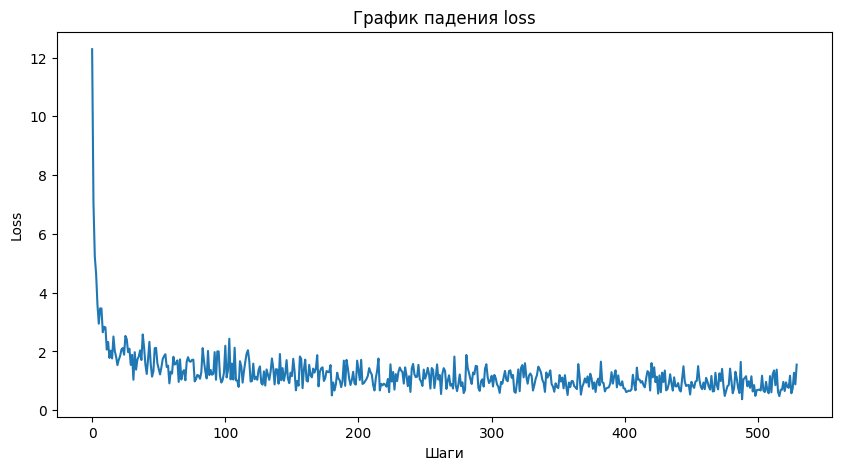

In [86]:
plt.figure(figsize=(10, 5))
plt.plot(history_loss)
plt.title("График падения loss")
plt.xlabel("Шаги")
plt.ylabel("Loss")
plt.show()

In [90]:
def evaluate_baseline_on_val(model, val_loader, tokenizer):
    model.eval()
    predictions = []
    references = []

    with torch.no_grad():
        for batch in tqdm(val_loader):
            input_ids = batch['input_ids'].to(device)
            mask = batch['attention_mask'].to(device)

            gen_tokens = model.generate(
                input_ids=input_ids,
                attention_mask=mask,
                max_length=100,
                num_beams=4,
                no_repeat_ngram_size=2,
                early_stopping=True
            )
            # -------------------

            preds = tokenizer.batch_decode(gen_tokens, skip_special_tokens=True)

            labels = batch['labels'].cpu().numpy()
            labels[labels == -100] = tokenizer.pad_token_id
            refs = tokenizer.batch_decode(labels, skip_special_tokens=True)

            predictions.extend(preds)
            references.extend(refs)

    b_score = bleu.compute(predictions=predictions, references=[[r] for r in references])
    r_score = rouge.compute(predictions=predictions, references=references)

    return {
        "BLEU": b_score['bleu'],
        "ROUGE-1": r_score['rouge1'],
        "ROUGE-L": r_score['rougeL']
    }, predictions, references

metrics_base, preds_base, refs_base = evaluate_baseline_on_val(baseline_model, val_loader_base, tokenizer)

df_res = pd.DataFrame([metrics_base])
df_res.index = ["Baseline (No Graph)"]
print(df_res)

  0%|          | 0/14 [00:00<?, ?it/s]

                         BLEU   ROUGE-1   ROUGE-L
Baseline (No Graph)  0.055639  0.262317  0.228584


In [91]:
val_graphs = [item['input_graph'] for item in val_data_list]

min_len = min(len(val_graphs), len(preds_base))
val_graphs = val_graphs[:min_len]
preds_base = preds_base[:min_len]

def evaluate_factual_coverage_v2(inputs, predictions):
    total_facts = 0
    covered_facts = 0
    regex_pattern = r"<T>\s*(.*?)(?=\s*(?:\[SEP\]|<H>|$))"
    for graph_str, pred_text in zip(inputs, predictions):
        matches = re.findall(regex_pattern, graph_str)
        objects = [m.strip() for m in matches if len(m.strip()) > 0]
        for obj in objects:
            total_facts += 1
            if obj.lower() in pred_text.lower():
                covered_facts += 1
    return covered_facts / total_facts if total_facts > 0 else 0

fact_cov_base = evaluate_factual_coverage_v2(val_graphs, preds_base)

print(f"Factual Coverage: {fact_cov_base*100:.2f}%")

Factual Coverage: 4.69%
